# Intersections Drone (InD) dataset

The following tests contain the evaluation of Explainable Boosting Machines (EBM) on [InD](https://levelxdata.com/ind-dataset/) traffic forcasting dataset. 
Interestingly, without dense road network data, the model give 0.54 m of final error for 20 modes ([State-of-the-art](https://arxiv.org/abs/2204.11561) has the same error).

The code assume existance of InD dataset files extracted in a neighbour folder.

##  Intelligible Pedestrians Destination Prediction with Additive Models 

In [3]:
import pandas as pd
import numpy as np
#from pygam import LinearGAM, s, f,l,te
from utils import *
from matplotlib import pyplot as plt

from interpret import show
from interpret.glassbox import ExplainableBoostingRegressor

from sklearn.cluster import KMeans

import glob,os
%matplotlib inline
import os

# Read data

In [ ]:
files_ids = [x for x in range(32)]
root = './indds/'
all_files = []
all_meta_and_statics = []
for x in files_ids:
    idx = '{0:02d}'.format(x)
    meta_info_file = os.path.join(root,f'{idx}_recordingMeta.csv')
    file_ = os.path.join(root,f'{idx}_tracks.csv')
    static_file = os.path.join(root,f'{idx}_tracksMeta.csv')

    meta_info = pd.read_csv(meta_info_file)
    static_ = pd.read_csv(static_file)

    all_files.append(pd.read_csv(file_))
    all_meta_and_statics.append((meta_info,static_))

In [5]:
all_files[1]

,recordingId,trackId,frame,trackLifetime,xCenter,yCenter,heading,width,length,xVelocity,yVelocity,xAcceleration,yAcceleration,lonVelocity,latVelocity,lonAcceleration,latAcceleration
0,1,0,0,0,132.04457,-31.99325,261.76756,1.87348,4.76888,-1.21104,-8.36881,-0.12537,-0.32349,8.45598,0.00024,0.33811,0.07776
1,1,0,1,1,131.99811,-32.32607,261.71362,1.87348,4.76888,-1.21586,-8.39354,-0.13030,-0.31042,8.48115,-0.00652,0.32596,0.08420
2,1,0,2,2,131.95175,-32.66156,261.66163,1.87348,4.76888,-1.22183,-8.41795,-0.13493,-0.28546,8.50615,-0.01185,0.30201,0.09211
3,1,0,3,3,131.90537,-32.99971,261.60869,1.87348,4.76888,-1.22902,-8.44088,-0.13830,-0.24874,8.52987,-0.01594,0.26626,0.10052
4,1,0,4,4,131.85674,-33.34127,261.55991,1.87348,4.76888,-1.23661,-8.46085,-0.13973,-0.20126,8.55072,-0.01862,0.21959,0.10868
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193243,1,384,25803,163,127.82768,-52.71701,248.49337,2.15288,5.00815,-1.41196,-3.12439,-0.56420,-0.35718,3.42449,0.16823,0.53915,0.39398
193244,1,384,25804,164,127.77067,-52.84447,248.23404,2.15288,5.00815,-1.43545,-3.14057,-0.56498,-0.35995,3.44895,0.16854,0.54379,0.39122
193245,1,384,25805,165,127.71150,-52.97219,247.96729,2.15288,5.00815,-1.45846,-3.15613,-0.56509,-0.36119,3.47276,0.16797,0.54680,0.38832
193246,1,384,25806,166,127.65147,-53.10000,247.70221,2.15288,5.00815,-1.48097,-3.17124,-0.56504,-0.36152,3.49602,0.16700,0.54888,0.38562


# SDD like split

In [166]:
in_tracks = []
tracks = []
classes_dict = {'pedestrian':0,
                'bicycle':1,
                'car':2,
                'truck_bus':3}
in_ = []
all_tracks = []
samples_in = 0
Xs, Xs_test = [],[]
ys, ys_test = [],[]
trajs_full_len = 0
traj_lens = [5082,1643,4879,1628,784,1528,3652,2654,6136,2285,2197,3351,6011,4857,5409,3851,7695,5419,
             9048,6160,7966,10141,10568,10033,8905,11929,11792,14993,11123,14404,1098,707]
for i in (files_ids):
    useful_tracks = (all_meta_and_statics[i][1]['numFrames']>(25*8))*(all_meta_and_statics[i][1]['class']=='pedestrian')
    in_tracks = all_meta_and_statics[i][1]['trackId'][useful_tracks].to_numpy().tolist()

    ds = all_files[i].groupby('trackId')#['xCenter'].to_numpy()
    trajs_full_len = int(traj_lens[i]*0.8)
    for track_id, track_rows in ds:
        if track_id in in_tracks:
            track = track_rows.to_dict(orient="list")
            tracks.append(track)
            #add as data point
            in_ = [track["xCenter"], track["yCenter"],track["heading"],track["xVelocity"], track["yVelocity"],
             track["xAcceleration"], track["yAcceleration"], track["width"], track["length"]]#,[track_class]*len(track["xCenter"])]
            track_array = np.array(in_).T[::10,:] # 25 equal 1s, then 10 equal 400ms

            # rotation

            samples_in += 1
            for ii in range(track_array.shape[0]-20):
                X = track_array[(ii):(ii+8),:].copy()#+4
                c, s = np.cos(X[-1,2]*np.pi/180), np.sin(X[-1,2]*np.pi/180)
                R_mat = np.array([[c, -s], [s, c]])
                
                out = (track_array[(ii+19):(ii+20),:2] - X[-1:,:2]).copy()
                X[:,:2] -= X[-1:,:2]

                # rotate positions
                X[:,:2] = (R_mat @ X[:,:2].T).T
                
                # ===== speed and acc
                X[:,3:5] = (R_mat @ X[:,3:5].T).T
                X[:,5:7] = (R_mat @ X[:,5:7].T).T
                

                out[0,:2] = R_mat @ out[0,:2]
                y = out.copy()#[:,:2]
                trajs_full_len -= 1
                if trajs_full_len>0:# 80% data
                    Xs.append(X[:,:].flatten())
                    ys.append(y)
                else:
                    Xs_test.append(X[:,:].flatten())
                    ys_test.append(y)


Xs = np.vstack(Xs)
ys = np.vstack(ys)
Xs_test = np.vstack(Xs_test)
ys_test = np.vstack(ys_test)
print(Xs.shape)
print(ys.shape)
print(Xs_test.shape)
print(ys_test.shape)

(158297, 72)
(158297, 2)
(39631, 72)
(39631, 2)


## Format



In [171]:
yx_all = np.hstack((ys,Xs))
yx_test_all = np.hstack((ys_test,Xs_test))
np.save('ind_train.npy',yx_all)
np.save('ind_test.npy',yx_test_all)

# Save or load saved

In [5]:
if os.path.isfile('ind_train.npy'):
    yx_all = np.load('ind_train.npy')
    yx_test_all = np.load('ind_test.npy')
else:
    np.save('ind_train.npy',yx_all)
    np.save('ind_test.npy',yx_test_all)


# Normlize features



In [6]:
use_kmeans = True
if use_kmeans:
    modes_n = 50
    clusterer = KMeans(n_clusters=modes_n,random_state=42).fit(yx_all[:,:2])#,n_init=10

c:\Users\yasin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


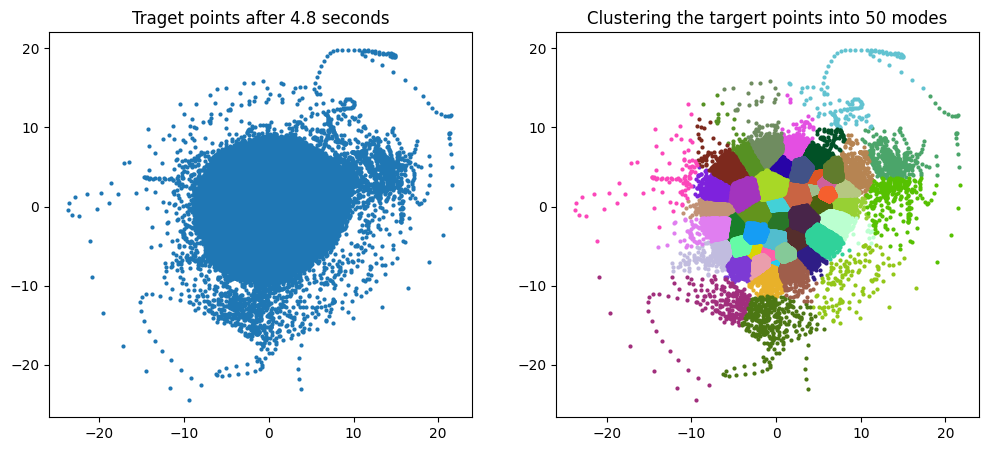

In [7]:
sub_modes = []
if use_kmeans:
    plt.figure(figsize=(12,5))
    plt.subplot(122)
    for i in range(modes_n):
        cluster_i = (clusterer.labels_==i)
        sub_modes.append(yx_all[cluster_i])
        color = np.array([[np.random.rand() for _  in range(3)]])
        plt.scatter(yx_all[cluster_i][:,0],yx_all[cluster_i][:,1],c=color,marker='.',linewidths=0.001)
    plt.title(f'Clustering the targert points into {modes_n} modes')
    plt.subplot(121)
    plt.scatter(yx_all[:,0],yx_all[:,1],marker='.',linewidths=0.001)
    plt.title('Traget points after 4.8 seconds')
    plt.show()

In [8]:
if not(use_kmeans):
    x_ranges = 9
    yx_sorted_x = sorted(yx_all,key=lambda x: x[0])
    single_len = (len(yx_sorted_x)//x_ranges)+(x_ranges-1)
    print(single_len)
    sub_modes_x = [yx_sorted_x[(i*single_len):(i+1)*single_len] for i in range(x_ranges)]
    
    y_ranges = 4
    sub_modes = []
    for sub_mode_x in sub_modes_x:
        yx_sorted_y = sorted(sub_mode_x,key=lambda x: x[1])
        single_len = (len(yx_sorted_y)//y_ranges)+(y_ranges-1)
        sub_modes.extend([np.array(yx_sorted_y[(i*single_len):(i+1)*single_len]) for i in range(y_ranges)])

In [9]:
if not(use_kmeans):
    plt.scatter(ys[:,0],ys[:,1],marker='.',linewidths=0.01)
    yx_range = [-20,25]
    for i,sub_mode_x in enumerate(sub_modes_x):#x
        sub_mode = np.array(sub_mode_x)
        xmin,xmax = sub_mode[:,0].min(),sub_mode[:,0].max()

        if i == 0:
            plt.plot([xmin,xmin],yx_range,'k',linewidth=1)
        plt.plot([xmax,xmax],yx_range,'k',linewidth=1)
        #print([xmin,xmax])
        offset = i*y_ranges
        for j in range(y_ranges):
            mode = sub_modes[offset+j]
            #print(len(mode))
            if len(mode)==0:
                continue
            ymin,ymax = mode[:,1].min(),mode[:,1].max()
            #print(ymin,ymax)
            if j==0:
                plt.plot([xmin,xmax],[ymin,ymin],'k',linewidth=1)
            plt.plot([xmin,xmax],[ymax,ymax],'k',linewidth=1)
            #print(len(mode))
    plt.show()

In [10]:

f_names = []
for ii in range(8):
    for f in ["xCenter","yCenter","heading","xVelocity","yVelocity","xAcceleration","yAcceleration","width","length"]:#,'track_class']:
        f_names.append(f'{f}_{ii}')

if os.path.isfile('ind_gam_allx_'):
    gam_allx = ExplainableBoostingRegressor()._from_json('ind_gam_allx_')
    gam_ally = ExplainableBoostingRegressor()._from_json('ind_gam_ally_')
else:
    gam_allx = ExplainableBoostingRegressor(feature_names=f_names).fit(yx_all[:,2:],yx_all[:,0])
    print('done training on x axis')
    gam_allx.to_json('ind_gam_allx_')
    gam_ally = ExplainableBoostingRegressor(feature_names=f_names).fit(yx_all[:,2:],yx_all[:,1])
    print('done training on y axis')
    gam_ally.to_json('ind_gam_ally_')

c:\Users\yasin\AppData\Local\Programs\Python\Python310\lib\site-packages\interpret\glassbox\_ebm\_json.py:407: UserWarning: JSON formats are in beta. The JSON format may change in a future version without compatibility between releases.
  warn(


In [11]:
errorsx = abs(gam_allx.predict(yx_test_all[:,2:])-yx_test_all[:,0]) 

print('MinFDEx')
print(f'all error: {errorsx.mean()}')

MinFDEx
all error: 0.6626991014145401


In [12]:
errorsy = abs(gam_ally.predict(yx_test_all[:,2:])-yx_test_all[:,1]) 

print('MinFDEx')
print(f'all error: {errorsy.mean()}')

MinFDEx
all error: 0.6785008101301472


In [13]:
print(f'final error: {np.linalg.norm([errorsx.mean(),errorsy.mean()])}')

final error: 0.948437371871704


In [14]:
global_ex_x  = gam_allx.explain_global()
global_ex_y  = gam_ally.explain_global()

local_ex_x = gam_allx.explain_local(yx_test_all[:10,2:])
local_ex_y = gam_ally.explain_local(yx_test_all[:10,2:])

show([global_ex_x,local_ex_x])

<!-- http://127.0.0.1:7480/1565219289856/ -->
 Open in new window

# Train GAMx

In [51]:
GAMs_x = []
for j,mode in enumerate(sub_modes):
    if len(mode)==0: continue

    gam = ExplainableBoostingRegressor(feature_names=f_names).fit(mode[:,2:],mode[:,0])

    print(f'mode {j} trained')
    GAMs_x.append(gam)



mode 0 trained
mode 1 trained
mode 2 trained
mode 3 trained
mode 4 trained
mode 5 trained
mode 6 trained
mode 7 trained
mode 8 trained
mode 9 trained
mode 10 trained
mode 11 trained
mode 12 trained
mode 13 trained
mode 14 trained
mode 15 trained
mode 16 trained
mode 17 trained
mode 18 trained
mode 19 trained
mode 20 trained
mode 21 trained
mode 22 trained
mode 23 trained
mode 24 trained
mode 25 trained
mode 26 trained
mode 27 trained
mode 28 trained
mode 29 trained
mode 30 trained
mode 31 trained
mode 32 trained
mode 33 trained
mode 34 trained
mode 35 trained
mode 36 trained
mode 37 trained
mode 38 trained
mode 39 trained
mode 40 trained
mode 41 trained
mode 42 trained
mode 43 trained
mode 44 trained
mode 45 trained
mode 46 trained
mode 47 trained
mode 48 trained
mode 49 trained


In [52]:
errors = [abs(gam_.predict(yx_test_all[:,2:])-yx_test_all[:,0]) for gam_ in GAMs_x]

print('error for each single mode')
for i,error in enumerate(errors):
    print(f'mode {i} error: {error.mean()}')

print('MinFDEx')
min_errorsx=np.sort(np.vstack(tuple(errors)).T,axis=1)
x_error = min_errorsx[:,0].mean()
print(x_error)

error for each single mode
mode 0 error: 2.9929324066728746
mode 1 error: 3.539280944812258
mode 2 error: 4.199756880409438
mode 3 error: 7.607778306169885
mode 4 error: 3.1752252360852813
mode 5 error: 7.0378797937670505
mode 6 error: 5.25426989524584
mode 7 error: 3.509232532563077
mode 8 error: 4.31520836734324
mode 9 error: 6.003614812845568
mode 10 error: 9.843551618970332
mode 11 error: 4.386564757754006
mode 12 error: 4.003268953042639
mode 13 error: 4.283592907638192
mode 14 error: 3.633775082983981
mode 15 error: 3.1230557255717466
mode 16 error: 7.593687379615286
mode 17 error: 7.31161862347445
mode 18 error: 9.317326589045074
mode 19 error: 5.659224596737978
mode 20 error: 6.019505610272951
mode 21 error: 5.113321774166966
mode 22 error: 3.3355739482315276
mode 23 error: 3.377450745495128
mode 24 error: 6.144253490790917
mode 25 error: 3.1730683641421575
mode 26 error: 3.6338125694087764
mode 27 error: 4.715028552412585
mode 28 error: 5.524310266217797
mode 29 error: 7.67440

In [53]:
GAMs_y = []
for j,mode in enumerate(sub_modes):
    if len(mode)==0: continue

    gam = ExplainableBoostingRegressor(feature_names=f_names).fit(mode[:,2:],mode[:,1])

    print(f'mode {j} trained')
    GAMs_y.append(gam)

mode 0 trained
mode 1 trained
mode 2 trained
mode 3 trained
mode 4 trained
mode 5 trained
mode 6 trained
mode 7 trained
mode 8 trained
mode 9 trained
mode 10 trained
mode 11 trained
mode 12 trained
mode 13 trained
mode 14 trained
mode 15 trained
mode 16 trained
mode 17 trained
mode 18 trained
mode 19 trained
mode 20 trained
mode 21 trained
mode 22 trained
mode 23 trained
mode 24 trained
mode 25 trained
mode 26 trained
mode 27 trained
mode 28 trained
mode 29 trained
mode 30 trained
mode 31 trained
mode 32 trained
mode 33 trained
mode 34 trained
mode 35 trained
mode 36 trained
mode 37 trained
mode 38 trained
mode 39 trained
mode 40 trained
mode 41 trained
mode 42 trained
mode 43 trained
mode 44 trained
mode 45 trained
mode 46 trained
mode 47 trained
mode 48 trained
mode 49 trained


In [14]:
errorsy = [abs(gam_.predict(yx_test_all[:,2:])-yx_test_all[:,1]) for gam_ in GAMs_y]

print('error for each single mode')
for i,error in enumerate(errorsy):
    print(f'mode {i} error: {error.mean()}')

print('MinFDEx')
min_errorsy=np.sort(np.vstack(tuple(errorsy)).T,axis=1)
y_error = min_errorsy[:,0].mean()
print(y_error)

error for each single mode
mode 0 error: 3.3855725141766655
mode 1 error: 6.152369874201373
mode 2 error: 4.122474766552658
mode 3 error: 3.6446759215882434
mode 4 error: 5.91777818796958
mode 5 error: 4.173541421064438
mode 6 error: 5.714257187249809
mode 7 error: 4.8536199640047455
mode 8 error: 5.375898308520161
mode 9 error: 3.450187424317526
mode 10 error: 6.104624223650457
mode 11 error: 4.874441294584289
mode 12 error: 4.926242965156302
mode 13 error: 3.5042933899211297
mode 14 error: 5.189124606874788
mode 15 error: 3.716117662084551
mode 16 error: 3.920010776272171
mode 17 error: 5.007566323105902
mode 18 error: 10.227030775755741
mode 19 error: 8.238759570302902
mode 20 error: 4.204308284177736
mode 21 error: 3.389844942108395
mode 22 error: 3.6686454022136186
mode 23 error: 4.1658318767076485
mode 24 error: 3.4053797490531985
mode 25 error: 7.212782311779752
mode 26 error: 7.695812195622695
mode 27 error: 4.5244296453920185
mode 28 error: 4.406862831151687
mode 29 error: 3.6

In [54]:
ecl_dists = [np.sqrt((err_x**2)+(err_y**2)) for err_x,err_y in zip(errors,errorsy)]
min_errors_ecl=np.sort(np.vstack(tuple(ecl_dists)).T,axis=1)
xy_error = min_errors_ecl[:,0].mean()
print(xy_error)

0.5120635884763063


# Probability Prediction


In [55]:
from scipy import stats
 
def get_std(model):
    all_devs = 0
    for m in model.standard_deviations_:
        if len(m.shape)>1:
            all_devs += m.mean(axis=0).mean(axis=0)
        else:
            all_devs += m.mean(axis=0)
    return all_devs

In [56]:
loglikelihoods = []
probs = []
all_preds = []
global_preds = []
global_std = get_std(gam_allx)
for m,gam in enumerate(GAMs_x):
    predsx = gam.predict(yx_test_all[:,2:])
    all_preds.append(predsx)
    if len(global_preds):
        pass
    else:
        global_preds = gam_allx.predict(yx_test_all[:,2:])
    likely = stats.norm.logpdf(predsx,loc=global_preds,scale=global_std)
    #likely += stats.norm.logpdf(predsx,loc=predsx,scale=get_std(gam))/5


    loglikelihoods.append(likely)

In [18]:
loglikelihoodsy = []
all_predsy = []
probs_y = []
global_preds = []
global_std = get_std(gam_ally)
for m,gam in enumerate(GAMs_y):
    predsy = gam.predict(yx_test_all[:,2:])
    all_predsy.append(predsy)
    
    if len(global_preds)==0:
        global_preds  =gam_ally.predict(yx_test_all[:,2:])
    likely = stats.norm.logpdf(predsy,loc=global_preds,scale=global_std)
    #likely += stats.norm.logpdf(predsy,loc=predsy,scale=get_std(gam))/2

    
    loglikelihoodsy.append(likely)

In [19]:

n_hoods = np.nan_to_num(np.array(loglikelihoodsy)+np.array(loglikelihoods)*1,nan=-np.inf)
n_hoods_sorted = np.sort(n_hoods.T,axis=1)
top_6y = []
for j in range(20):
    A = n_hoods_sorted[:,-1-j]
    pred = np.array(all_predsy).T[(n_hoods.T == A[:,None])]
    top_6y.append(pred)
    
print(np.sort(abs(np.array(top_6y).T-yx_test_all[:,1:2]),axis=1)[:,0].mean())

top_6 = []
for j in range(20):
    A = n_hoods_sorted[:,-1-j]
    pred = np.array(all_preds).T[(n_hoods.T == A[:,None])]
    top_6.append(pred)
    
print(np.sort(abs(np.array(top_6).T-yx_test_all[:,:1]),axis=1)[:,0].mean())

FDE_errors = np.sqrt((np.array(top_6).T - yx_test_all[:,:1])**2 + (np.array(top_6y).T - yx_test_all[:,1:2])**2)
np.sort(FDE_errors,axis=1)[:,0].mean()

0.13794606011895927
0.13916568810363672


0.515776391198612

# Global explanation

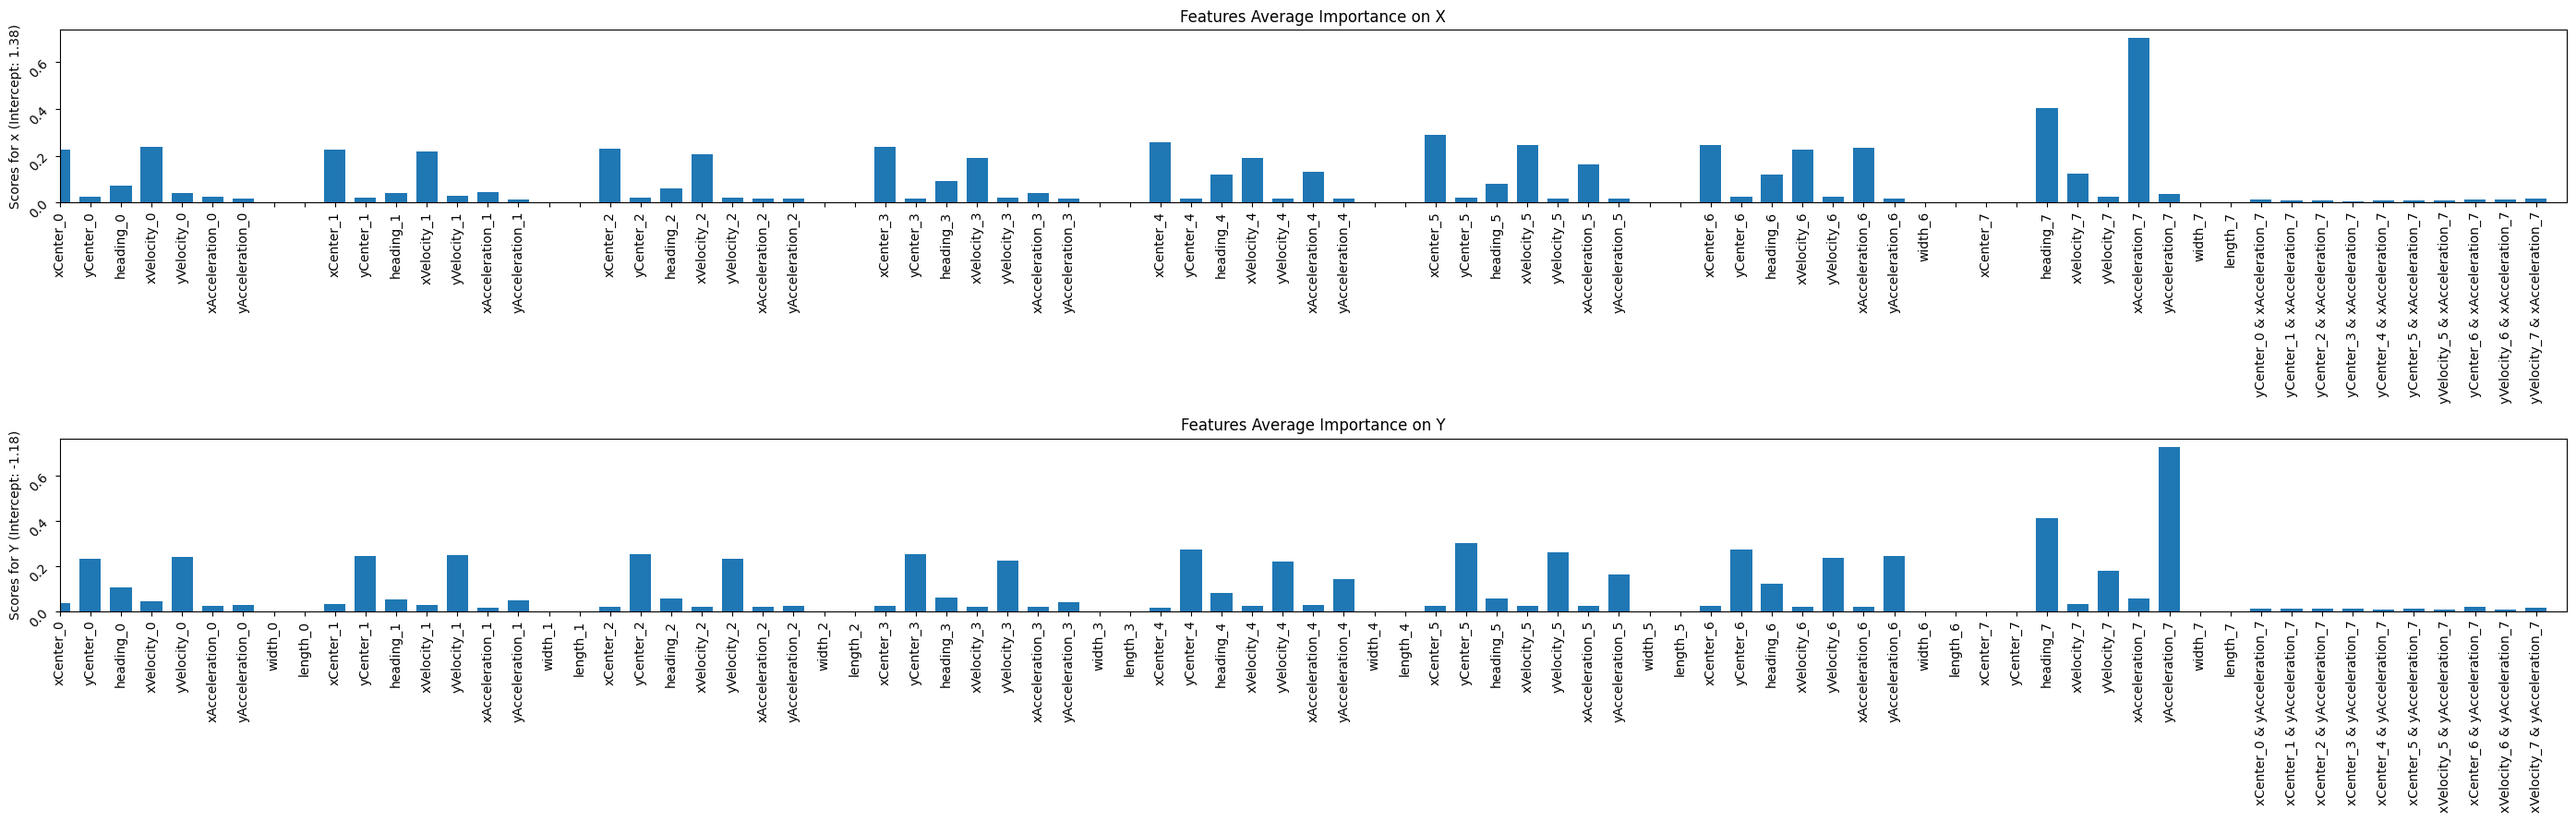

In [17]:
scores = global_ex_x.data()['scores'][0:]
names_ = global_ex_x.data()['names'][0:]
names = [['',n][bool(scores[i])] for i,n in enumerate(names_)]

plt.figure(figsize=(28,9))

plt.subplot(211)
plt.bar(range(0,len(scores)*10,10),scores,width=7,align='center')
plt.xticks(np.arange(0,len(scores)*10,10),names,rotation=90)
plt.xlim(0,len(scores)*10)
plt.yticks(rotation=45)
plt.ylabel(f'Scores for x (Intercept: {np.round(gam_allx.intercept_,2)[0]})')
plt.title('Features Average Importance on X')


scores = global_ex_y.data()['scores'][0:]
names = global_ex_y.data()['names'][0:]

plt.subplot(212)
plt.bar(range(0,len(scores)*10,10),scores,width=7,align='center')
plt.xticks(np.arange(0,len(scores)*10,10),names,rotation=90)
plt.xlim(0,len(scores)*10)
plt.yticks(rotation=45)
plt.ylabel(f'Scores for Y (Intercept: {np.round(gam_ally.intercept_,2)[0]})')
plt.title('Features Average Importance on Y')

plt.tight_layout()
plt.show()

# Best 6 Features

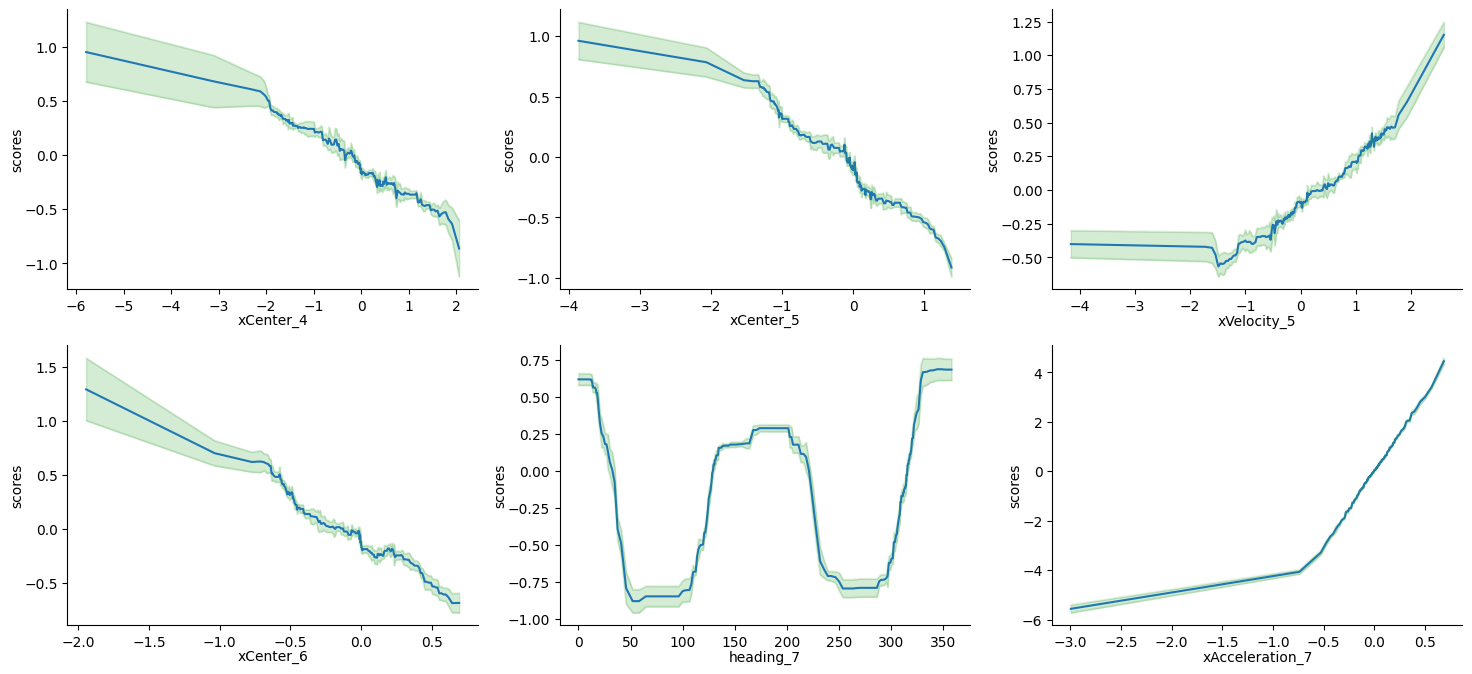

In [20]:
import seaborn as sns
names = global_ex_x.data()['names']
scores = global_ex_x.data()['scores']

best_6_mask = scores>(np.sort(scores)[-7])
p_in = 1
plt.figure(figsize=(18,8))
sigma_factor = 3
for k_i in np.arange(len(scores))[best_6_mask]:
    f_dict = global_ex_x.data(key=k_i)
    x_data = f_dict['names'][:-1]
    y_data = f_dict['scores']
    up_data = f_dict['upper_bounds']
    up_data_m = sigma_factor*(up_data-y_data) + y_data
    low_data = f_dict['lower_bounds']
    low_data_m = sigma_factor*(low_data-y_data) + y_data
    ax = plt.subplot(2,3,p_in)
    p_in += 1
    plt.plot(x_data,y_data)
    #plt.plot(x_data,up_data_m ,c='r',ls='--')
    #plt.plot(x_data,low_data_m,c='r',ls='--')
    plt.xlabel(names[k_i],labelpad=0.5)
    plt.ylabel("scores",labelpad=0.1)
    
    ax.plot(x_data, low_data_m, color='tab:green', alpha=0.1)
    ax.plot(x_data, up_data_m, color='tab:green', alpha=0.1)
    ax.fill_between(x_data, low_data_m, up_data_m,color='tab:green', alpha=0.2)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
plt.show()

In [18]:
show(global_ex_x)

<!-- http://127.0.0.1:7480/1564639102624/ -->

# Explanation

In [19]:
local_ex = gam_allx.explain_local(yx_test_all[:10,2:],yx_test_all[:10,0])
show(local_ex)

<!-- http://127.0.0.1:7480/1565264551824/ -->

# Best Prediction

In [38]:
def get_all_modes(input_arr):
    
    out = []
    for gamx,gamy in zip(GAMs_x,GAMs_y):
        
        out.append([gamx.predict(input_arr)[0],gamy.predict(input_arr)[0]])
    return np.array(out)

C:\Users\yasin\AppData\Local\Temp\ipykernel_20596\1614058608.py:39: DeprecationWarning:

In future, it will be an error for 'np.bool_' scalars to be interpreted as an index

C:\Users\yasin\AppData\Local\Temp\ipykernel_20596\1614058608.py:53: DeprecationWarning:

In future, it will be an error for 'np.bool_' scalars to be interpreted as an index



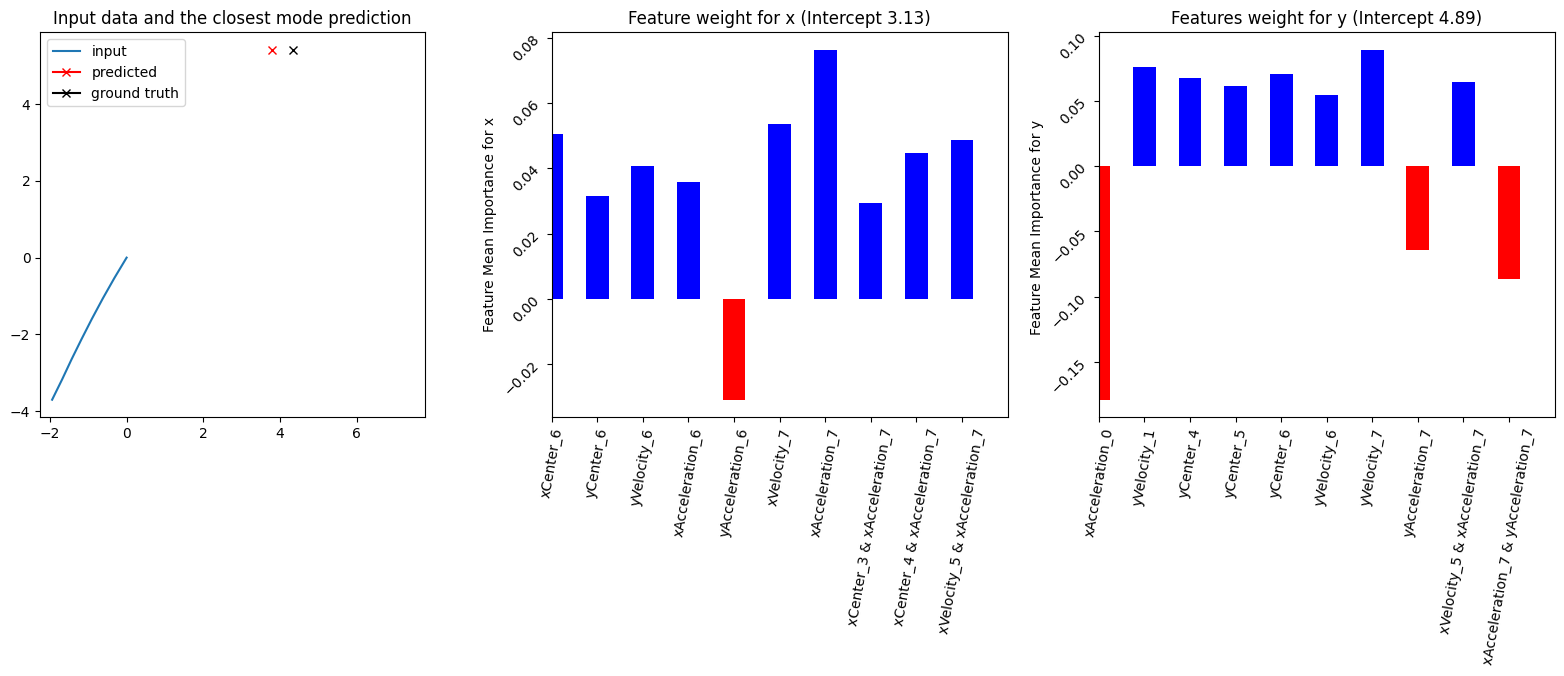

In [88]:

key_ = 100

pred_20 = get_all_modes(yx_test_all[key_,2:])
best_mode = np.linalg.norm(pred_20 - yx_test_all[key_,:2],axis=1).argmin()
local_ex_x_mode = GAMs_x[best_mode].explain_local(yx_test_all[:key_+2,2:])
local_ex_y_mode = GAMs_y[best_mode].explain_local(yx_test_all[:key_+2,2:])

data_x = local_ex_x_mode.data(key=key_)
data_y = local_ex_y_mode.data(key=key_)
names = data_x['names']
input_data = [[],[]]

# draw input 
for s_ in range(8):
    f_ind_x = names.index(f'xCenter_{s_}')
    f_ind_y = names.index(f'yCenter_{s_}')
    input_data[0].append(data_x['values'][f_ind_x])
    input_data[1].append(data_x['values'][f_ind_y])
    
plt.figure(figsize=(20,5))
plt.title(f'global models ex {key_}')
plt.subplot(131)
plt.plot((input_data[0]),input_data[1],label='input')
#draw output
plt.plot(data_x['perf']['predicted'],data_y['perf']['predicted'],marker='x',color='r',label='predicted')
plt.plot(yx_test_all[key_,0],yx_test_all[key_,1],marker='x',color='k',label='ground truth')
plt.legend()
plt.ylim([-1,1])
plt.title('Input data and the closest mode prediction')
plt.axis('square')

#plt.show()

plt.subplot(132)
#draw best 10 amounts to x
scores = np.array(data_x['scores'])
mask_best_6 = np.sort(np.abs(scores))[-11]<np.abs(scores)

plt.bar(range(0,len(scores[mask_best_6])*10,10),scores[mask_best_6],width=5,align='center',color=[['r','b'][x>0] for x in scores[mask_best_6]])
plt.xticks(np.arange(0,len(scores[mask_best_6])*10,10),np.array(names)[mask_best_6],rotation=80)
plt.xlim(0,len(scores[mask_best_6])*10)
plt.yticks(rotation=45)
plt.ylabel('Feature Mean Importance for x')
plt.title(f'Feature weight for x (Intercept {np.round(data_x["extra"]["scores"][0],decimals=2)})')
#plt.ylim([-1,1])
#plt.show()

plt.subplot(133)
#draw best 10 amounts to y
scores = np.array(data_y['scores'])
mask_best_6 = np.sort(np.abs(scores))[-11]<np.abs(scores)

plt.bar(range(0,len(scores[mask_best_6])*10,10),scores[mask_best_6],width=5,align='center',color=[['r','b'][x>0] for x in scores[mask_best_6]])
plt.xticks(np.arange(0,len(scores[mask_best_6])*10,10),np.array(names)[mask_best_6],rotation=80)
plt.xlim(0,len(scores[mask_best_6])*10)
plt.yticks(rotation=45)
plt.ylabel('Feature Mean Importance for y ')
plt.title(f'Features weight for y (Intercept {np.round(data_y["extra"]["scores"][-1],decimals=2)})')
#plt.ylim([-1,1])

plt.show()